# Simulating Two-Mode Squeezed States on IBM Quantum: Exploring Continuous-Variable Quantum Simulation with Qiskit

### Team Squiz:

teammember 1

teammember 2

.

.

.

.

## Introduction

Although qubits, the building blocks of quantum computers, differ from photons typically used in experiments with two-mode squeezed states, simulating these states using qubits offers valuable insights into entanglement dynamics and related quantum phenomena. By exploring the behavior and properties of entangled qubit states, we can deepen our understanding of entanglement generation, manipulation, and utilization. This knowledge serves as a foundation for developing quantum information processing protocols and applications.

### What are two-mode squeezed states?

A squeezed coherent state is a quantum state that combines characteristics of both coherent states and squeezed states. It is obtained by applying a squeezing operator to a coherent state.

A coherent state is a quantum state that exhibits classical-like properties and is represented by a wavefunction that has a Gaussian distribution in the phase space. Coherent states are eigenstates of the annihilation operator and are characterized by a well-defined phase and a minimum uncertainty in both position and momentum.

A squeezed state, on the other hand, is a nonclassical state that exhibits reduced quantum fluctuations in one observable (quadrature) at the expense of increased fluctuations in the conjugate quadrature. Squeezed states can be generated using techniques such as SPDC (spontaneous parametric down-conversion) or other nonlinear optical processes.

![](https://www.rp-photonics.com/img/squeezed_light.png)

A squeezed coherent state combines the properties of both coherent states and squeezed states. It is obtained by applying a squeezing operator to a coherent state, resulting in a state that exhibits both the coherent-like behavior and reduced fluctuations in one of the quadratures.


Mathematically, a two-mode squeezed coherent state can be expressed as:

$$
|\text{TMSV}\rangle = \frac{1}{\cosh r} \sum_{n=0}^\infty (-e^{i \phi}\tanh r)^n  |nn\rangle.
$$ 

From now on, we fix  𝜙=𝜋  for simplicity so that the state is of the form:

$$
|\text{TMSV}\rangle = \frac{1}{\cosh r} (|00\rangle + \tanh r \, |11\rangle + (\tanh r)^2|22\rangle + \ldots).
$$

The so-called squeezing parameter  𝑟  is usually very small and so the leading term  |00⟩  corresponding to vacuum is prevalent, while the only non-negligible contribution comes from the first higher-order term  |11⟩ . This term corresponds to a Bell state. To study the general scenario, the effect of higher orders cannot be neglected anymore and the squeezing parameter can be kept as a free parameter ( 0<𝑟<1 ).
The two-mode squuezed vacuum with a general squeezing parameter  𝑟  is the state we decided to generate. Due to a finite number of qubits the infinite series has to be truncated and so we introduce a cutoff  𝑁 , such that the state lives in a  2𝑁 -dimensional Hilbert space and contains  2𝑁  terms, for details see below.


Squeezed coherent states find applications in various areas of quantum physics, including quantum communication, quantum metrology, and quantum information processing. They offer a compromise between classical-like properties and nonclassical features, making them useful for tasks that require both coherent behavior and reduced quantum noise.

<div class="alert alert-block  alert-info">
<b> Note 1: </b> *"Self-describing quantum computer"*: A superconducting quantum computer models a quantum state produced by SPDC, which state can be used in a photonic quantum computer. The photonic computer can then in turn simulate the superconducting computer... :open_mouth: </div>

<div class="alert alert-block  alert-info">
<b> Note 2: </b> As a matter of fact, when the phase  𝜙  in the state above is not fixed and fluctuates randomly, the pure state  |TMSV⟩  turns into a classical mixture:

$$
\rho_1 = \frac{1}{\cosh^2(r)} \sum_{n=0}^\infty \tanh^{2n}(r)
|n \rangle \langle n|.
$$
    
One could think of making use of the natural decoherence of IBM Quantum computers to our advantage and simulate an approximation to this mixed state as well. This way, we could (maybe) turn the bottleneck of the quantum computers to our advantage.</div>



In [1]:
import qiskit

from qiskit import QuantumCircuit
from qiskit.quantum_info import state_fidelity
from qiskit import Aer, transpile
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Rn(n, r=1, phi=np.pi):
    '''
    Return the Rn coefficients of the states.
    '''
    return (1/np.cosh(r))*( ( -np.exp(1j*phi)*np.tanh(r) )**n )

In [3]:
def getTargetStateBasic(N, r=1, phi=np.pi):
    '''
    Return a list of the necessary Rn coefficients for a given N.
    
    N: cutoff
    2*N: Number of qbits
    2**N: Number of states
    '''
    Nstates = 2**N
    
    L = [Rn(n, r=r, phi=phi) for n in range(Nstates)]
    L = L / np.linalg.norm(L)
    return L    

In [4]:
def prettyBin(num, N):
    '''
    Returns *num* as a binary string, zero-padded to N digits.
    ex: prettyBin(3, 6) -> '000011'
    '''
    return '{num:0{N}b}'.format(num=num, N=N)

In [5]:
def getStateIndex(idx_v1_dec, N):
    '''
    Returns the decimal index of the 'ith state'.
    Ex: N=3, 2nd state -> idx_v1 = '010' -> idx_v2 = '010010' -> idx_v2 = 18
    getStateIndex(2, 3) -> 18
    '''
    idx_v1_bin = prettyBin(idx_v1_dec, N)
    idx_v2_bin = 2 * idx_v1_bin
    idx_v2_dec = int(idx_v2_bin, 2)
    return idx_v2_dec

In [6]:
def getTargetStateAdvanced(N, r=1, phi=np.pi):
    '''
    Return a list of the necessary Rn coefficients for a given N, but mapped to a system of 2*N qubits.
    
    N: cutoff
    2*N: Number of qbits
    2**N: Number of states
    '''
    
    L = getTargetStateBasic(N, r=r, phi=phi)

    Nqbits = 2*N
    LL = 0j*np.ones(2**Nqbits)

    for idx,val in enumerate(L):
        idx_v2 = getStateIndex(idx, N)
        LL[idx_v2] = val
        
    return LL

In [7]:
def getReferenceQuantumCircuit(N, r=1, phi=np.pi):
    '''
    Returns a quantum circuit representing the TMSV state with parameters:
    
        * cutoff *N*,
        * squeezing parameter *r*
        * *phi*
    '''
    Nqbits = 2*N
    qc = QuantumCircuit(Nqbits)
    x = getTargetStateAdvanced(N, r=r, phi=phi)
    qc.initialize(x, qubits=range(Nqbits))
    return qc

In [8]:
def checkQuantumCircuit_v1(qc, N, r=1, phi=np.pi):
    qc_ref = getReferenceQuantumCircuit(N, r=r, phi=phi)

    backend = Aer.get_backend('statevector_simulator')

    sv_ref = execute(qc_ref, backend).result().get_statevector(qc_ref)
    sv = execute(qc, backend).result().get_statevector(qc)

    return state_fidelity(sv_ref, sv)

In [9]:
def checkQuantumCircuit_v2(qc, N, r=1, phi=np.pi):
    qc_ref = getReferenceQuantumCircuit(N, r=r, phi=phi)
    state_ref = DensityMatrix(qc_ref)
    state = DensityMatrix(qc)
    return state_fidelity(state_ref, state)

In [10]:
# cutoff
N = 2
# squeezing parameter
r = 1
# phi
phi = np.pi

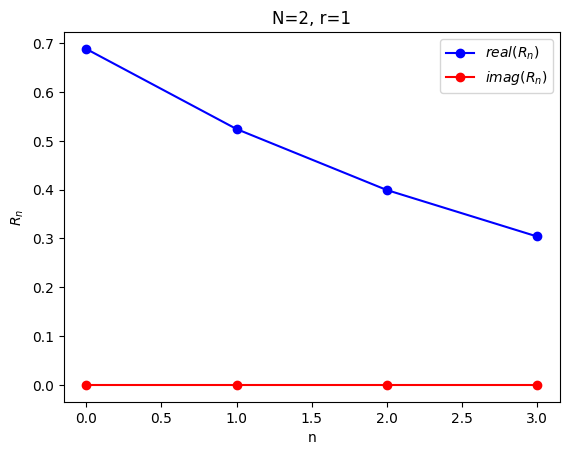

In [11]:
Nstates = 2**N
n = range(Nstates)
y = getTargetStateBasic(N, r=r, phi=phi)
#y = Rn(n)
plt.plot(n, np.real(y), 'b-o', label='$real(R_n)$')
plt.plot(n, np.imag(y), 'r-o', label='$imag(R_n)$')
plt.xlabel('n')
plt.ylabel('$R_n$')
plt.title(f'N={N}, r={r}')
plt.legend()
plt.show()

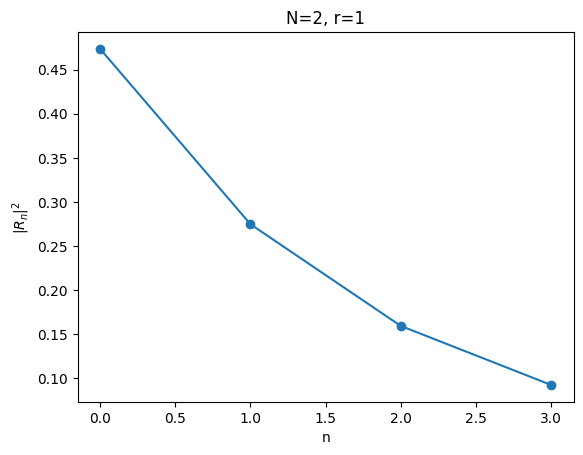

In [12]:
# probabilities
P = np.abs(y)**2
plt.plot(n, P, '-o')
plt.xlabel('n')
plt.ylabel('$|R_n|^2$')
plt.title(f'N={N}, r={r}')
plt.show()

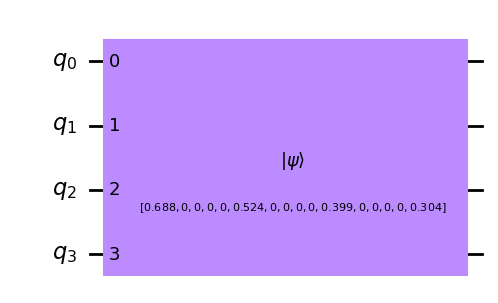

In [13]:
qc = getReferenceQuantumCircuit(N, r=r, phi=phi)
qc.draw()

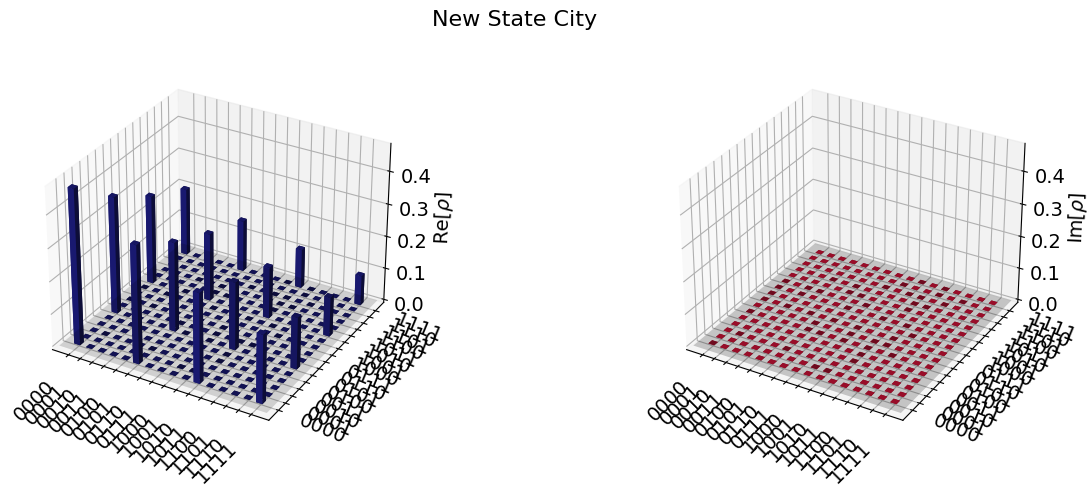

In [14]:
state = DensityMatrix(qc)
plot_state_city(state, color=['midnightblue', 'crimson'], title="New State City")

In [15]:
# Calculate fidelity
f1 = checkQuantumCircuit_v1(qc, N, r=r, phi=phi)
f2 = checkQuantumCircuit_v2(qc, N, r=r, phi=phi)
print(f1)
print(f2)

1.0
1.0000000000000004


In [16]:
circuit = transpile(qc, basis_gates=['cx', 'id', 'rz', 'x', 'sx'])

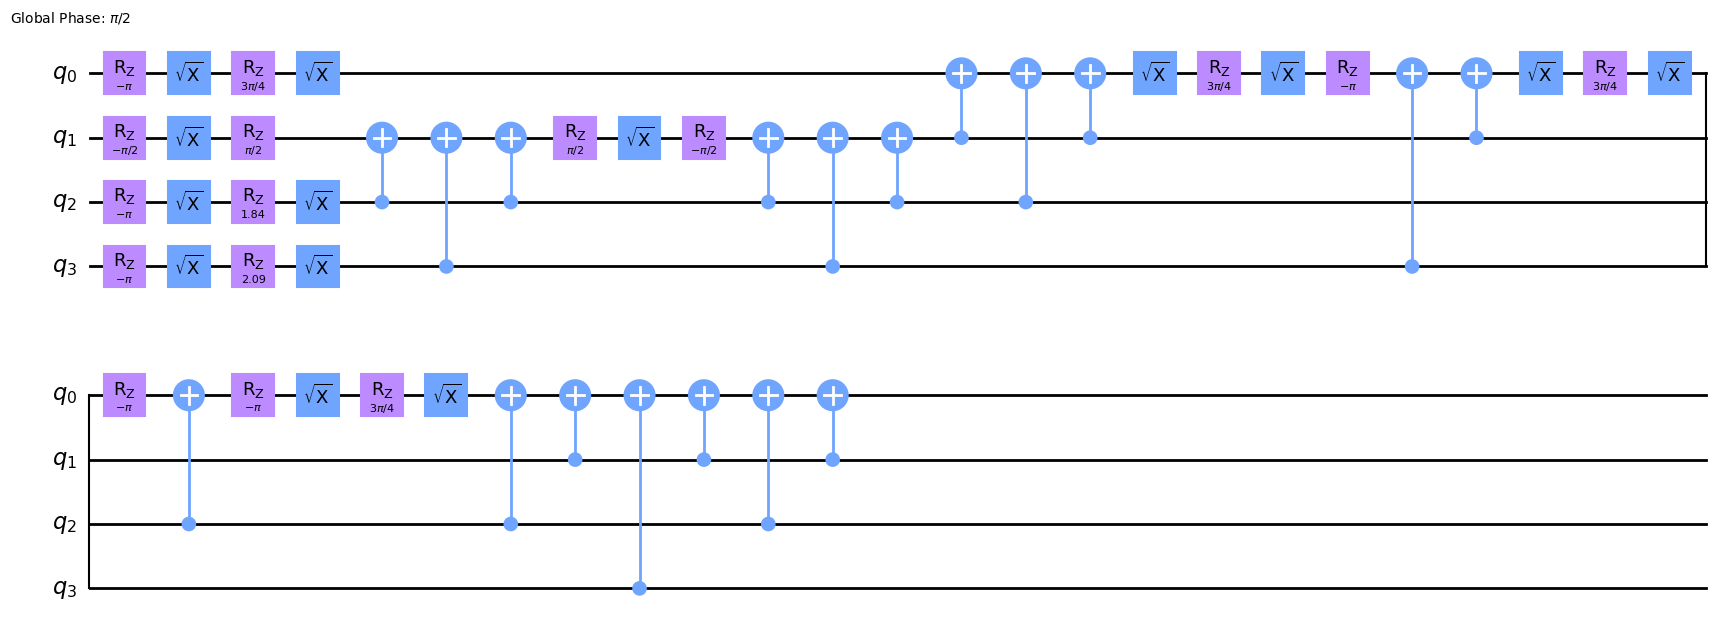

In [17]:
circuit.draw()

In [18]:
circuit.depth()

37

In [19]:
y[1]/y[0]

(0.7615941559557649-9.326838453405575e-17j)

In [20]:
np.tanh(r)

0.7615941559557649

In [21]:
P

array([0.47357604, 0.27468625, 0.15932508, 0.09241263])

In [22]:
y

array([0.68816861+0.00000000e+00j, 0.52410519-6.41843748e-17j,
       0.39915545-9.77648895e-17j, 0.30399446-1.11685753e-16j])

In [23]:
# Calculate fidelity
f1 = checkQuantumCircuit_v1(qc, N, r=r, phi=phi)
f2 = checkQuantumCircuit_v2(qc, N, r=r, phi=phi)
print(f1)
print(f2)

1.0
1.0000000000000004


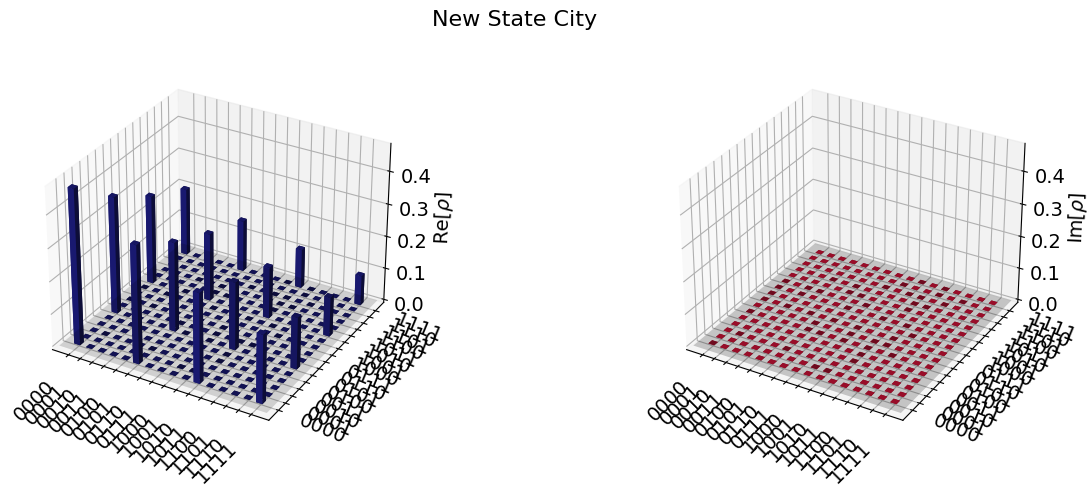

In [24]:
state = DensityMatrix(qc)
plot_state_city(state, color=['midnightblue', 'crimson'], title="New State City")

In [25]:
qc.depth()

1

In [26]:
circuit.depth()/qc.depth()

37.0

In [27]:
##Implementing a 4 qubit using Quantum fourier transform
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

def TMSVQuantumCircuit(N, r=1, phi=np.pi):
    n = 2*N #Number of registers
    qreg_q = QuantumRegister(n, 'q')
    #creg_c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg_q)


    R = np.tanh(r)#-0.5
    for i in range(N):

        theta =  2*np.arctan(R**(2**i))
        qc.ry(theta, qreg_q[i])
        qc.cx(qreg_q[i], qreg_q[N+i])
    return qc


In [28]:
r

1

In [29]:
r = 0.1
phi = np.pi

qc_ref_depth = []
qc_TMSV_depth = []

qc_ref_f1 = []
qc_TMSV_f1 = []

qc_ref_f2 = []
qc_TMSV_f2 = []

for N in range(1,4):
    qc_ref = getReferenceQuantumCircuit(N, r=r, phi=phi)
    qc_ref = transpile(qc_ref, basis_gates=['cx', 'id', 'rz', 'x', 'sx'])
    
    qc_TMSV = TMSVQuantumCircuit(N, r=r, phi=phi)
    qc_TMSV = transpile(qc_TMSV, basis_gates=['cx', 'id', 'rz', 'x', 'sx'])

    qc_ref_depth.append(qc_ref.depth())
    qc_TMSV_depth.append(qc_TMSV.depth())
    
    f1_ref = checkQuantumCircuit_v1(qc_ref, N, r=r, phi=phi)
    f2_ref = checkQuantumCircuit_v2(qc_ref, N, r=r, phi=phi)

    f1_TMSV = checkQuantumCircuit_v1(qc_TMSV, N, r=r, phi=phi)
    f2_TMSV = checkQuantumCircuit_v2(qc_TMSV, N, r=r, phi=phi)


    qc_ref_f1.append(f1_ref)
    qc_ref_f2.append(f2_ref)

    qc_TMSV_f1.append(f1_TMSV)
    qc_TMSV_f2.append(f2_TMSV)
#qc.measure(qreg_q, creg_c)
#qc.draw()

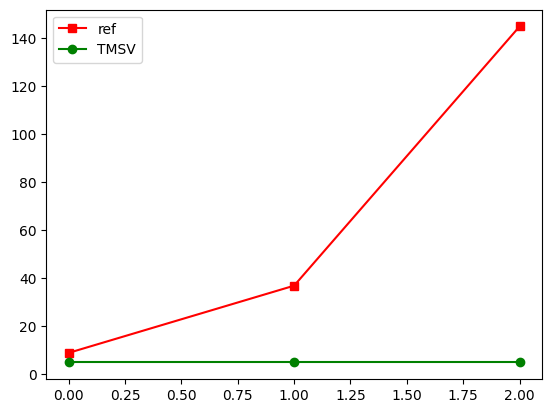

In [30]:
#plt.plot(qc_ref_depth,'ro')
#plt.plot(qc_ref_depth,'r')
plt.plot(qc_ref_depth,'rs-', label='ref')
plt.plot(qc_TMSV_depth,'go-', label='TMSV')
#plt.plot(qc_TMSV_depth,'g')
plt.legend()


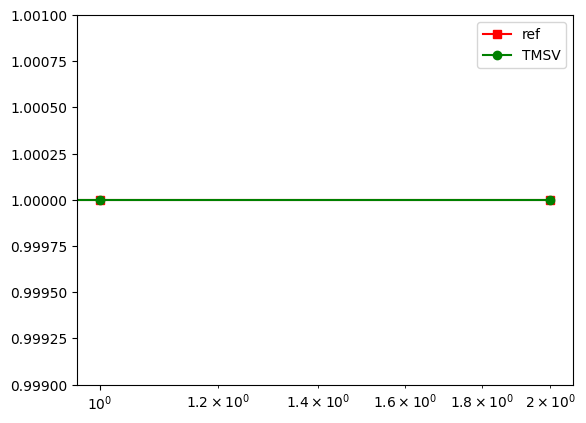

In [31]:
#plt.plot(qc_ref_depth,'ro')
#plt.plot(qc_ref_depth,'r')
plt.plot(qc_ref_f1,'rs-', label='ref')
plt.plot(qc_TMSV_f1,'go-', label='TMSV')
#plt.plot(qc_TMSV_depth,'g')
plt.ylim([0.999,1.001])
plt.xscale('log')
plt.legend()

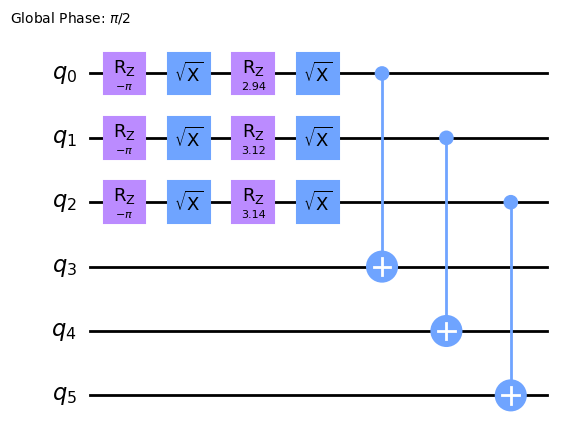

In [32]:
qc_TMSV.draw()

In [33]:
print(dict(qc_ref.count_ops()))
print(dict(qc_TMSV.count_ops()))

{'cx': 98, 'rz': 34, 'sx': 32}
{'rz': 6, 'sx': 6, 'cx': 3}


In [34]:
qc_TMSV_f1

[1.0, 1.0, 1.0]

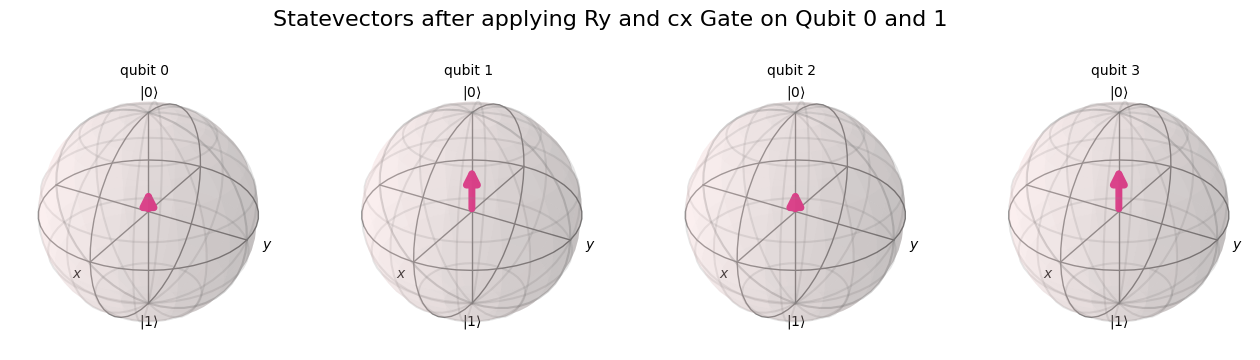

In [35]:
# execute the quantum circuit
from qiskit.visualization import plot_state_city, plot_bloch_multivector
N = 2
qc = TMSVQuantumCircuit(N, r=1, phi=np.pi)

backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(qc, backend)).result()
psi  = result.get_statevector(qc)

plot_bloch_multivector(psi, title='Statevectors after applying Ry and cx Gate on Qubit 0 and 1')


In [36]:
#Running on a quantum computer


In [ ]:
shots = 4096

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibm_lagos')


job = execute(qc, backend=backend, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

result = job.result()
plot_histogram(result.get_counts(qc))



/tmp/ipykernel_270/2829770284.py:5: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  if not IBMQ.active_account():


Job Status: job is queued (None)

In [ ]:
shots = 4096

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider()
backend_name = "ibmq_jakarta"

job = execute(qc, backend=backend_name, shots=shots)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

result = job.result()
plot_histogram(result.get_counts(qc))